# HW4


<b> Gamze Atmaca </b>, <b> Bulut Fıçıcı </b>


In [1]:
import sys
from pyspark import SparkConf, SparkContext, SQLContext
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import corr
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
sc = SparkContext.getOrCreate()
sqlcont = SQLContext(sc)

# Logistic Regression

In [5]:
# Creating a new dataframe to use logistic regression. 

schema = StructType() \
      .add("Open Time",DoubleType(),True) \
      .add("Open",DoubleType(),True) \
      .add("High",DoubleType(),True) \
      .add("Low",DoubleType(),True) \
      .add("Close",DoubleType(),True) \
      .add("Volume",DoubleType(),True) \
      .add("Close Time",DoubleType(),True) \
      .add("Quote asset volume",DoubleType(),True) \
      .add("Number of trades",IntegerType(),True) \
      .add("Taker buy base asset volume",DoubleType(),True) \
      .add("Taker buy quote asset volume",DoubleType(),True) \
      .add("Ignore",StringType(),True) \

df = sqlcont.read.format("csv") \
      .option("header", True) \
      .schema(schema) \
      .load('csv/btc_2021_hourly.csv')

In [6]:
df=df.drop("Open Time").drop("Close Time").drop("Ignore")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 3632 rows 9 columns in the data.


In [7]:
df.show(1,vertical=True)

-RECORD 0-------------------------------------------
 Open                         | 28995.13            
 High                         | 29470.0             
 Low                          | 28960.35            
 Close                        | 29409.99            
 Volume                       | 5403.068471         
 Quote asset volume           | 1.583578168180572E8 
 Number of trades             | 103896              
 Taker buy base asset volume  | 3160.041701         
 Taker buy quote asset volume | 9.261399193555292E7 
only showing top 1 row



In [8]:
df.printSchema()

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Quote asset volume: double (nullable = true)
 |-- Number of trades: integer (nullable = true)
 |-- Taker buy base asset volume: double (nullable = true)
 |-- Taker buy quote asset volume: double (nullable = true)



In [9]:
#let's see the statistics
numeric_features = [t[0] for t in df.dtypes if (t[1] == 'int' or t[1] == 'double')]
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Open,3632,47763.097794603425,9758.78706201656,28995.13,64577.25
High,3632,48127.30659691632,9730.966051054123,29125.32,64854.0
Low,3632,47363.61166024227,9795.233758474216,28130.0,64280.0
Close,3632,47765.06958700446,9755.696878505894,29000.01,64577.26
Volume,3632,3756.4256987472536,2804.2740859967826,0.0,44239.811778
Quote asset volume,3632,1.7048093031037322E8,1.116667597067393E8,0.0,1.5144648252185037E9
Number of trades,3632,96093.00633259912,49861.75701668211,0,799206
Taker buy base asset volume,3632,1845.195042224671,1369.1507788728309,0.0,19904.321262
Taker buy quote asset volume,3632,8.377469610648279E7,5.4824905157718435E7,0.0,6.839264854908676E8


In [10]:
#adding the target variable
# Target variable is Up_Down which takes the value of "Yes" if BTC rises, "No" if it falls between the opening and closing time.
df=df.withColumn("Up_Down", \
   when(((df.Close-df.Open) >= 0), lit('Yes')) \
     .when(((df.Close-df.Open) < 0), lit('No')) \
  )

In [11]:
df.groupby("Up_Down").count().show()

+-------+-----+
|Up_Down|count|
+-------+-----+
|     No| 1779|
|    Yes| 1853|
+-------+-----+



In [12]:
#null check
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Up_Down
0,0,0,0,0,0,0,0,0,0,0


Our dataset does not contain any categorical data except the target. So there is no need to encode

In [13]:
#grouping our target variable with the column 'Number of trades'
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['Up_Down','Number of trades']).\
   groupBy('Up_Down').\
       agg(F.count('Number of trades').alias('UserCount'),
           F.mean('Number of trades').alias('NoT_AVG'),
           F.min('Number of trades').alias('NoT'),
           F.max('Number of trades').alias('NoT_MAX')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       drop(col('total')).sort(desc("Percent"))
tab.show()

+-------+---------+-----------------+-----+-------+------------------+
|Up_Down|UserCount|          NoT_AVG|  NoT|NoT_MAX|           Percent|
+-------+---------+-----------------+-----+-------+------------------+
|    Yes|     1853|94364.88127361036|    0| 799206|51.018722466960355|
|     No|     1779|97893.01517706577|32918| 571162|48.981277533039645|
+-------+---------+-----------------+-----+-------+------------------+



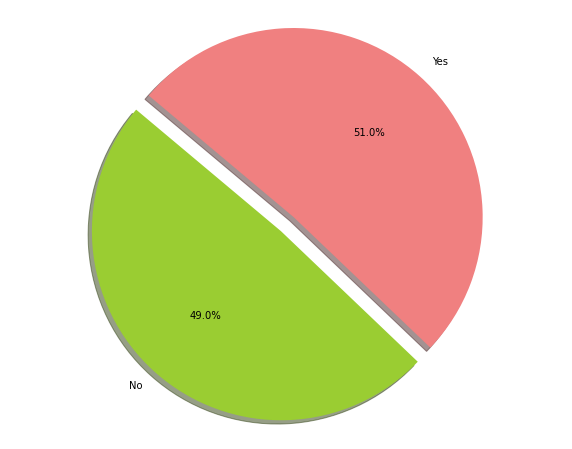

In [14]:
# Data to plot
labels = list(tab.select('Up_Down').distinct().toPandas()['Up_Down'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['yellowgreen', 'lightcoral']
explode = (0.1, 0.0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [15]:
#Correlation Matrix

In [16]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,28995.13,29470.00,28960.35,29409.99,5403.068471,1.583578e+08,103896,3160.041701,9.261399e+07
1,29410.00,29465.26,29120.03,29194.65,2384.231560,6.984265e+07,57646,1203.433506,3.525275e+07
2,29195.25,29367.00,29150.02,29278.40,1461.345077,4.276078e+07,42510,775.915666,2.270555e+07
3,29278.41,29395.00,29029.40,29220.31,2038.046803,5.961464e+07,55414,1003.342834,2.934638e+07
4,29220.31,29235.28,29084.11,29187.01,1469.956262,4.286454e+07,41800,679.846742,1.982719e+07


In [17]:
col_names = numeric_features_df.columns
features= numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df= pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open,1.000000,0.999428,0.998985,0.998744,-0.319449,-0.042727,-0.121478,-0.322548,-0.043383
High,0.999428,1.000000,0.998687,0.999359,-0.305863,-0.027954,-0.107775,-0.307128,-0.026637
Low,0.998985,0.998687,1.000000,0.999225,-0.346126,-0.071284,-0.149084,-0.346527,-0.068885
Close,0.998744,0.999359,0.999225,1.000000,-0.323427,-0.047111,-0.125812,-0.323105,-0.043981
Volume,-0.319449,-0.305863,-0.346126,-0.323427,1.000000,0.939635,0.925198,0.990117,0.926133
Quote asset volume,-0.042727,-0.027954,-0.071284,-0.047111,0.939635,1.000000,0.946821,0.931000,0.988221
Number of trades,-0.121478,-0.107775,-0.149084,-0.125812,0.925198,0.946821,1.000000,0.916904,0.935690
Taker buy base asset volume,-0.322548,-0.307128,-0.346527,-0.323105,0.990117,0.931000,0.916904,1.000000,0.938579
Taker buy quote asset volume,-0.043383,-0.026637,-0.068885,-0.043981,0.926133,0.988221,0.935690,0.938579,1.000000


In [18]:
#Dropping the highly correlated features
df=df.drop("High").drop("Low")

In [19]:
df2=df
df3=df

In [20]:
df.columns

['Open',
 'Close',
 'Volume',
 'Quote asset volume',
 'Number of trades',
 'Taker buy base asset volume',
 'Taker buy quote asset volume',
 'Up_Down']

In [21]:
# Vectorize
assembler = VectorAssembler()\
         .setInputCols (['Open','Close',"Volume","Quote asset volume","Number of trades","Taker buy base asset volume","Taker buy quote asset volume"])\
         .setOutputCol ("vectorized_features")

assembler_df=assembler.transform(df)
assembler_df.toPandas().head()

,Open,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Up_Down,vectorized_features
0,28995.13,29409.99,5403.068471,1.583578e+08,103896,3160.041701,9.261399e+07,Yes,"[28995.13, 29409.99, 5403.068471, 158357816.81..."
1,29410.00,29194.65,2384.231560,6.984265e+07,57646,1203.433506,3.525275e+07,No,"[29410.0, 29194.65, 2384.23156, 69842653.67342..."
2,29195.25,29278.40,1461.345077,4.276078e+07,42510,775.915666,2.270555e+07,Yes,"[29195.25, 29278.4, 1461.345077, 42760776.7255..."
3,29278.41,29220.31,2038.046803,5.961464e+07,55414,1003.342834,2.934638e+07,No,"[29278.41, 29220.31, 2038.046803, 59614637.303..."
4,29220.31,29187.01,1469.956262,4.286454e+07,41800,679.846742,1.982719e+07,No,"[29220.31, 29187.01, 1469.956262, 42864538.704..."


In [22]:
label_indexer = StringIndexer()\
                 .setInputCol ("Up_Down")\
                 .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)
label_indexer_df.select("Up_Down", "label").toPandas().head()

,Up_Down,label
0,Yes,0.0
1,No,1.0
2,Yes,0.0
3,No,1.0
4,No,1.0


In [23]:
#Scale
scaler = StandardScaler()\
                 .setInputCol ("vectorized_features")\
                 .setOutputCol ("features")

scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features", "features").toPandas().head()

,vectorized_features,features
0,"[28995.13, 29409.99, 5403.068471, 15...","[2.9711817478686164, 3.0146477864433..."
1,"[29410.0, 29194.65, 2384.23156, 6984...","[3.0136942032960707, 2.9925745298957..."
2,"[29195.25, 29278.4, 1461.345077, 427...","[2.9916883947221904, 3.0011592574700..."
3,"[29278.41, 29220.31, 2038.046803, 59...","[3.0002099455534075, 2.9952047879203..."
4,"[29220.31, 29187.01, 1469.956262, 42...","[2.994256336807692, 2.99179139773252..."


In [24]:
#trying second methodology
pipeline_stages=Pipeline()\
                .setStages([assembler,label_indexer,scaler])
pipeline_model=pipeline_stages.fit(df3)
pipeline_df=pipeline_model.transform(df3)
pipeline_df.toPandas().head()

,Open,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Up_Down,vectorized_features,label,features
0,28995.13,29409.99,5403.068471,1.583578e+08,103896,3160.041701,9.261399e+07,Yes,"[28995.13, 29409.99, 5403.068471, 15...",0.0,"[2.9711817478686164, 3.0146477864433..."
1,29410.00,29194.65,2384.231560,6.984265e+07,57646,1203.433506,3.525275e+07,No,"[29410.0, 29194.65, 2384.23156, 6984...",1.0,"[3.0136942032960707, 2.9925745298957..."
2,29195.25,29278.40,1461.345077,4.276078e+07,42510,775.915666,2.270555e+07,Yes,"[29195.25, 29278.4, 1461.345077, 427...",0.0,"[2.9916883947221904, 3.0011592574700..."
3,29278.41,29220.31,2038.046803,5.961464e+07,55414,1003.342834,2.934638e+07,No,"[29278.41, 29220.31, 2038.046803, 59...",1.0,"[3.0002099455534075, 2.9952047879203..."
4,29220.31,29187.01,1469.956262,4.286454e+07,41800,679.846742,1.982719e+07,No,"[29220.31, 29187.01, 1469.956262, 42...",1.0,"[2.994256336807692, 2.99179139773252..."


# Model Training & Prediction

In [25]:
train, test = pipeline_df.randomSplit([0.8, 0.2], seed = 2021)
print("Training count: " + str(train.count()))
print("Test count: " + str(test.count()))

Training count: 2919
Test count: 713


In [26]:
train.groupBy("Up_Down").count().show()

+-------+-----+
|Up_Down|count|
+-------+-----+
|     No| 1432|
|    Yes| 1487|
+-------+-----+



In [27]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = "features", labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('label','features','rawPrediction','prediction','probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,1.0,"[2.9791304816105297, 2.9755988077036...","[0.11832307148680171, -0.11832307148...",0.0,"[0.5295463043642462, 0.4704536956357..."
1,0.0,"[2.988401100943144, 2.99951098977581...","[0.17787638962819796, -0.17787638962...",0.0,"[0.5443522169790758, 0.4556477830209..."
2,0.0,"[2.991014130599181, 3.00343177580230...","[0.17479676627872293, -0.17479676627...",0.0,"[0.5435882653848426, 0.4564117346151..."
3,0.0,"[3.034483672183004, 3.04242642731081...","[0.1374656930095023, -0.137465693009...",0.0,"[0.5343124073227662, 0.4656875926772..."
4,0.0,"[3.1112667800875187, 3.1439947737180...","[-0.008068806539898138, 0.0080688065...",1.0,"[0.49798280930922095, 0.502017190690..."


# Performance Metrics

In [28]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[102 245]
 [ 73 293]]


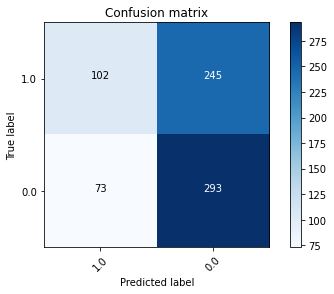

In [29]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [30]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy: ", accuracy)

Accuracy:  0.5539971949509116


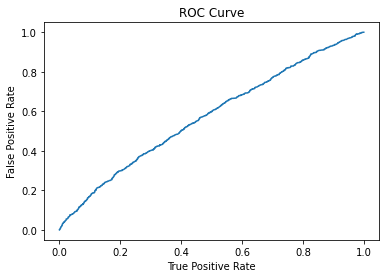

Training set areaUnderROC: 0.5735724509999144


In [31]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5344167808380974


# Cross Validation and Best Model

In [33]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

In [34]:
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.6773672855545594


In [35]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_f5bc5d6954c1, numClasses=2, numFeatures=7

In [36]:
best_model=cvModel.bestModel
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitti